# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [4]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [5]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [6]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

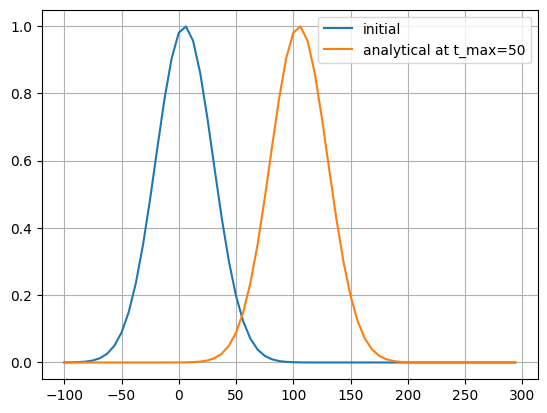

In [7]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [8]:
class One:
    def __radd__(self, o):
        return slice(o.start+1, o.stop+1)

    def __rsub__(self, o):
        return slice(o.start-1, o.stop-1)

def F(psi_l, psi_r, C):
    return (C + abs(C))/2* psi_l + (C - abs(C))/2* psi_r

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [9]:
nt = 10
i=slice(1,nx-2)
x,dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
dt=t_max/nt

C = u*dt/dx
one=One()

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [10]:
psi=psi_0(x)
for _ in range (nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

**7. comparing analytic and numerical solutions**

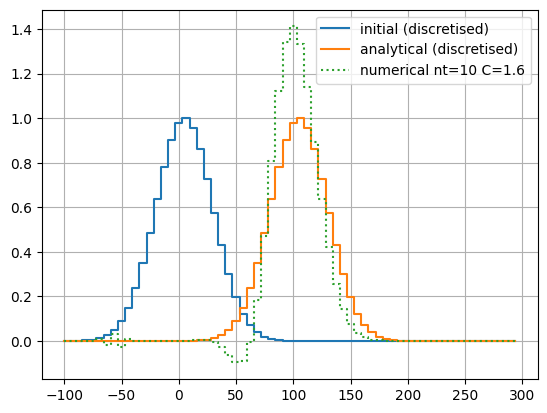

In [11]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid', linestyle=":")
pyplot.legend()
pyplot.grid()

# Assignment 3
31/03/2025 Jakub Mieszczak (jmieszczak@student.agh.edu.pl)

In this project, I examined the convergence characteristics of the upwind scheme to assess how well the numerical solution approximates the analytical one. 

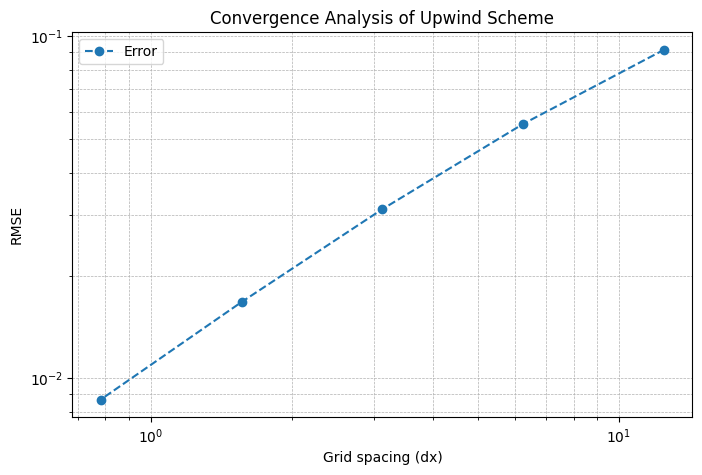

In [12]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x - self.x0) ** 2 / (2 * self.sigma ** 2))

class One:
    def __radd__(self, o):
        return slice(o.start + 1, o.stop + 1)
    def __rsub__(self, o):
        return slice(o.start - 1, o.stop - 1)

def F(psi_l, psi_r, C):
    return (C + abs(C)) / 2 * psi_l + (C - abs(C)) / 2 * psi_r

def upwind_scheme(dx, nt, C):
    x = np.arange(-100, 300, dx)
    nx = len(x)
    dt = C * dx / u
    psi = psi_0(x)
    i = slice(1, nx - 2)
    one = One()
    
    for _ in range(nt):
        psi[i] = psi[i] - (F(psi[i], psi[i + one], C) - F(psi[i - one], psi[i], C))
    return x, psi

def compute_rmse(dx, nt, C, t_max):
    x, psi_num = upwind_scheme(dx, nt, C)
    psi_exact = psi_0(x - u * t_max)
    return np.sqrt(np.mean((psi_num - psi_exact) ** 2))

u = 2
t_max = 50
psi_0 = Psi_0()
C = 0.5 

dx_values = [12.5, 6.25, 3.125, 1.5625, 0.78125] 
errors = []
for dx in dx_values:
    nt = int(t_max / (C * dx / u)) 
    rmse = compute_rmse(dx, nt, C, t_max)
    errors.append(rmse)

plt.figure(figsize=(8, 5))
plt.loglog(dx_values, errors, marker='o', linestyle='--', label='Error')
plt.xlabel('Grid spacing (dx)')
plt.ylabel('RMSE')
plt.title('Convergence Analysis of Upwind Scheme')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Conclusion:

The results demonstrate that as the spatial step size (dx) decreases, the RMSE decreases, indicating improved accuracy.
This confirms that refining the spatial resolution enhances the numerical solution's convergence towards the analytical result.
However, reducing dx increases the number of grid points, leading to higher computational costs.